In [19]:
import pandas as pd
import numpy as np

In [20]:
sequence_data = pd.read_parquet('../data/df.franka_cabinet_door_right_open.gzip')

# success_cond = lambda x: x < -0.8 # franka_cabinet_door_left_open termination condition
# success_cond = lambda x: x > -0.01 # franka_cabinet_door_left_close termination condition
success_cond = lambda x: x > 0.9 # franka_cabinet_door_right_open termination condition
# success_cond = lambda x: x < 0.01 # franka_cabinet_door_right_close termination condition
# success_cond = lambda x: x < 0.01 # franka_cabinet_drawer_top_close termination condition
# success_cond = lambda x: x > 0.35 # franka_cabinet_drawer_top_open termination condition

In [21]:
sequence_data

,env_id,timestep,state,action_1,action_2,action_3,action_4,action_5,action_6,action_7,action_8,action_9,terminated
0,0.0,0.0,8.811674e-11,-1.386814,2.769032,1.697226,1.352837,-0.862763,3.539762,-0.317070,0.375160,1.983379,0.0
1,1.0,0.0,8.811674e-11,-1.627505,3.040352,1.916609,2.172786,-0.381758,4.938103,-0.706162,-2.131596,3.560140,0.0
2,2.0,0.0,8.811674e-11,0.503301,2.387986,4.459977,0.009289,-1.440499,2.809430,1.473516,0.702299,0.172627,0.0
3,3.0,0.0,8.811674e-11,-2.713794,3.888752,2.476296,1.727180,0.076476,5.146926,0.837397,-1.392972,3.478379,0.0
4,4.0,0.0,8.811674e-11,-2.263393,4.100663,1.772099,3.220455,-1.246645,3.960524,1.638757,-0.679352,2.064516,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5119995,1019.0,4999.0,4.292735e-01,0.021163,0.111413,-1.002148,-1.168932,-1.676273,-0.596200,-0.903893,-0.518213,-1.442735,0.0
5119996,1020.0,4999.0,4.751922e-02,-1.166281,0.433064,-1.233717,0.696050,-1.462733,1.027868,-1.854015,-0.364660,-0.473055,0.0
5119997,1021.0,4999.0,4.564872e-02,0.160927,0.690868,-0.285455,-1.991646,-0.273461,-1.176324,0.168648,-0.967833,-1.988297,0.0
5119998,1022.0,4999.0,8.804665e-09,-0.672351,0.934115,0.397340,1.738319,-2.202129,2.320665,0.910250,1.998003,0.211246,0.0


In [22]:
def split_sequence(dataframe):
    total = 0
    success = 0
    timestep = 0
    sequence_arr = []
    last_row = None
    seq = None
    for _, row in dataframe.iterrows():
        data = np.array([
            timestep,
            row["state"],
            *(row[f"action_{action_idx}"] for action_idx in range(1, 10)) # 9 DOF
        ])
        if seq is None:
            seq = data
        else:
            seq = np.vstack((seq, data))
        
        if last_row is not None and last_row["terminated"] == 1.0 and success_cond(row["state"]):
            success += 1
            sequence_arr.append(seq)
            seq = None

        if last_row is not None and last_row["terminated"] == 1.0 and not success_cond(row["state"]):
            seq = None

        timestep += 1

        if row["terminated"] == 1.0:
            total += 1
            timestep = 0

        last_row = row

    return sequence_arr, total, success

In [23]:
max_envs = sequence_data["env_id"].max() + 1
sequence_arr = []
total = 0
success = 0
for env_id in range(int(max_envs)):
    cond = sequence_data["env_id"] == float(env_id)
    env_sequence_arr, env_total, env_success = split_sequence(sequence_data[cond])

    success += env_success
    total += env_total
    sequence_arr.extend(env_sequence_arr)

In [24]:
print(success / total * 100)
print(len(sequence_arr))

18.5643332396214
1981


In [25]:
# since 500 is the max episode length
timestep = np.arange(500).reshape(500, )

for sequence in sequence_arr:
    sequence.resize((500, 11), refcheck=False)
    sequence[:, 0] = timestep

In [26]:
sequence_arr[10][1]

array([ 1.00000000e+00,  2.93701202e-10, -1.98011696e+00,  2.50030875e+00,
        8.04713190e-01, -2.13225454e-01, -1.36645198e+00,  4.11600542e+00,
        1.33788073e+00,  1.80085897e+00,  2.40940213e+00])

In [27]:
graph_dataframe = pd.DataFrame(sequence_arr[0], columns=["timestamp", "state", "dof_1", "dof_2", "dof_3", "dof_4", "dof_5", "dof_6", "dof_7", "dof_8", "dof_9"])
graph_dataframe

,timestamp,state,dof_1,dof_2,dof_3,dof_4,dof_5,dof_6,dof_7,dof_8,dof_9
0,0.0,8.811674e-11,-1.386814,2.769032,1.697226,1.352837,-0.862763,3.539762,-0.317070,0.375160,1.983379
1,1.0,2.937012e-10,-1.016309,3.756284,1.287707,1.093786,0.074393,3.116296,-0.754897,0.440574,1.424452
2,2.0,6.167281e-10,-0.149580,2.670771,0.966712,-0.977889,-0.027614,3.451132,1.925013,1.430369,1.881394
3,3.0,1.057172e-09,-0.738294,3.338741,1.004499,-0.975304,0.065080,3.195780,2.607142,1.225082,2.732946
4,4.0,1.615006e-09,-0.278152,3.508643,0.695822,-1.442763,-1.307739,2.353221,0.504753,1.332423,1.496264
...,...,...,...,...,...,...,...,...,...,...,...
495,495.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
496,496.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
497,497.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
498,498.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


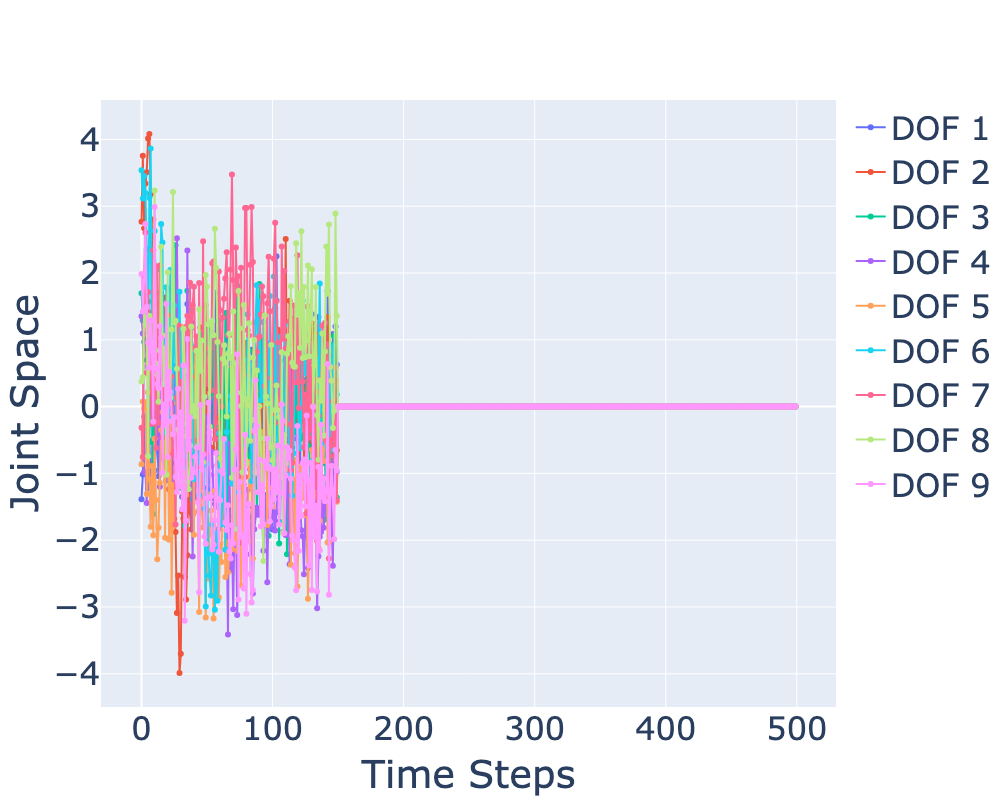

In [28]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
for dof_idx in range(1, 10):
    fig.add_trace(go.Scatter(x=graph_dataframe["timestamp"], y=graph_dataframe[f"dof_{dof_idx}"],
                        mode='lines+markers',
                        name=f'DOF {dof_idx}'))
fig.update_layout(
    autosize=True,
    height=800,
    font=dict(
        size=32
    ),
    xaxis_title="Time Steps",
    yaxis_title="Joint Space"
)
fig.show()

In [29]:
sequence_np = np.vstack(sequence_arr).reshape(-1, 500, 11)

In [30]:
# np.save('../data/sequence/franka_cabinet_door_right_close.npy', sequence_np)